# Set Up and Install PySpark

In [2]:
! pip install -q findspark
! pip install pyspark==3.5.4
! pip install gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.4-py2.py3-none-any.whl size=317849769 sha256=5029986bb466aa67bd35a1a21b250d908802f91cb10015a6f0e8fdaf9c35a669
  Stored in directory: /root/.cache/pip/wheels/8d/28/22/5dbae8a8714ef046cebd320d0ef7c92f5383903cf854c15c0c
Successfully built pyspark
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.5
    Uninstalling pyspark-3.5.5:
      Successfully uninstalled pyspark-3.5.5


In [1]:
import findspark
# automatically find the Spark installation directory
# based on common locations or environment variables.
findspark.init()

import pyspark as spark
print(spark.__version__)

3.5.4


In [2]:
from pyspark import SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml.feature import MinHashLSH, CountVectorizer
from pyspark.sql import functions as F
import pyspark.sql.types as T
from google.colab import drive

import time
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# MinHashLSH for Similar Dates

Dataset Schema:
root
 |-- Member_number: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- itemDescription: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)

Loaded data: 38765 transactions
Unique dates: 728

Data grouped by date:
+----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Date      |items_array                         

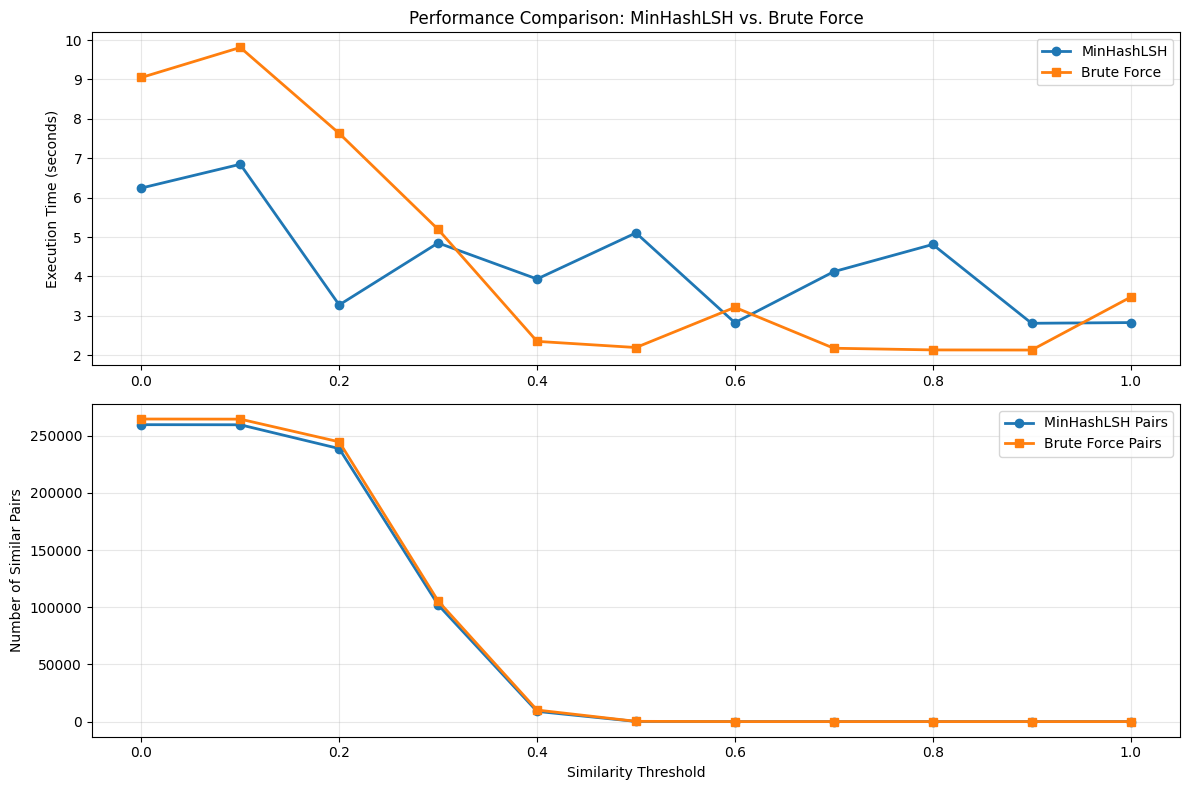


=== Conclusion ===
The MinHashLSH approach provides significant performance benefits compared to the manual approach,
especially for larger datasets and lower similarity thresholds. The speedup is attributable to LSH's
ability to efficiently narrow down candidate pairs before computing exact Jaccard similarities.
Analysis complete!


In [5]:
from pyspark import SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql import functions as F

class DateSimilarityAnalyzer:
    """
    Class to analyze similarity between dates based on items purchased.

    Implements two approaches:
    1. MinHashLSH algorithm for efficient similarity search
    2. Brute force comparison for validation
    """
    DEFAULT_HASH_TABLES = 10
    DEFAULT_SEED = 42
    FIGURE_WIDTH = 12
    FIGURE_HEIGHT = 8

    def __init__(self, spark=None, data_path=None):
        """
        Initialize the analyzer with Spark session and data path.

        Args:
            spark: SparkSession object
            data_path: Path to the baskets.csv file
        """
        self.spark = SparkSession.builder.appName("DateSimilarityAnalyzer").getOrCreate()
        self.data_path = data_path
        self.date_items_df = None

    def load_data(self):
        """
        Load and prepare data for similarity analysis.
        """
        try:
            # Load data
            df = self.spark.read.csv(self.data_path, header=True)

            # Data Preprocessing
            # Group items by date
            self.date_items_df = df.groupBy("Date").agg(F.collect_set("itemDescription").alias("items_array"))

            # Cache for performance
            self.date_items_df.cache()

            print(f"Loaded data: {df.count()} transactions")
            print(f"Unique dates: {self.date_items_df.count()}")

            return self.date_items_df

        except Exception as e:
            print(f"Error loading data: {e}")
            raise

    def run_minhash_lsh(self, threshold, num_hash_tables=DEFAULT_HASH_TABLES):
        """
        Implements MinHashLSH approach to find similar date pairs.

        Args:
            threshold: Jaccard similarity threshold
            num_hash_tables: Number of hash tables for LSH

        Returns:
            similar_pairs: DataFrame with similar date pairs
            execution_time: Time taken to execute the approach
        """
        start_time = time.time()

        # Create feature vectors (one-hot encoding for items to binary vector) -> input for MinHashLSH

        # Apply CountVectorizer for more scalable for large datasets with many unique items
        # Rather than Manual Sparse Vector Creation
        cv = CountVectorizer(inputCol="items_array", outputCol="features", binary=True)
        cv_model = cv.fit(self.date_items_df)
        df_features = cv_model.transform(self.date_items_df)

        # Set up the MinHashLSH transformer
        mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=num_hash_tables)
        mh_model = mh.fit(df_features)

        # Define a similarity threshold.
        # For a minimum Jaccard similarity of 50%
        # The Jaccard distance threshold maximum is 50%

        similarity_threshold = threshold
        distance_threshold = 1 - similarity_threshold

        # Use approxSimilarityJoin to find candidate pairs of dates with JaccardDistance below the threshold
        similar_pairs = mh_model.approxSimilarityJoin(df_features, df_features, distance_threshold, distCol="JaccardDistance")

        # Filter out self-joins(same date compared to itself)
        # And duplicate pairs (keep only pairs where datasetA.Date < datasetB.Date).
        similar_pairs = similar_pairs.filter(F.col("datasetA.Date") < F.col("datasetB.Date"))

        # Calculate actual Jaccard similarity (1 - distance)
        similar_pairs = similar_pairs.withColumn(
            "JaccardSimilarity", 1 - F.col("JaccardDistance")
        ).select(
            F.col("datasetA.Date").alias("date1"),
            F.col("datasetB.Date").alias("date2"),
            "JaccardSimilarity",
            "JaccardDistance"
        )

        end_time = time.time()
        execution_time = end_time - start_time

        return similar_pairs, execution_time

    def run_brute_force(self, threshold):
        """
        Implements brute force approach to find similar date pairs.

        Args:
            threshold: Jaccard similarity threshold

        Returns:
            similar_pairs: DataFrame with similar date pairs
            execution_time: Time taken to execute the approach
        """
        start_time = time.time()

        # Collect date_items_df to driver for easier processing
        date_items = self.date_items_df.collect()

        # Generate all possible date pairs
        all_pairs = []
        date_ids = sorted([row["Date"] for row in date_items])

        # Create a dictionary for faster lookups
        date_to_items = {row["Date"]: set(row["items_array"]) for row in date_items}

        # Calculate Jaccard similarity for all pairs
        for i, date1 in enumerate(date_ids):
            for date2 in date_ids[i+1:]:
                items1 = date_to_items[date1]
                items2 = date_to_items[date2]

                # Calculate Jaccard similarity
                intersection = len(items1.intersection(items2))
                union = len(items1.union(items2))
                similarity = intersection / union if union > 0 else 0

                # Keep pairs above threshold
                if similarity >= threshold:
                    distance = 1 - similarity
                    all_pairs.append((date1, date2, similarity, distance))

        # Convert results back to DataFrame
        if len(all_pairs) == 0:
            print("No similar pairs found.")
            # Create an empty DataFrame with the correct schema
            schema = T.StructType([
                T.StructField("date1", T.StringType(), True),
                T.StructField("date2", T.StringType(), True),
                T.StructField("JaccardSimilarity", T.DoubleType(), True),
                T.StructField("JaccardDistance", T.DoubleType(), True)
            ])
            similar_pairs = self.spark.createDataFrame([], schema) # Create an empty DataFrame
        else:
            similar_pairs = self.spark.createDataFrame(
                all_pairs, ["date1", "date2", "JaccardSimilarity", "JaccardDistance"]
            )

        end_time = time.time()
        execution_time = end_time - start_time

        return similar_pairs, execution_time

    def compare_approaches(self, thresholds):
        """
        Compares both approaches across different threshold values.

        Args:
            thresholds: List of threshold values to test

        Returns:
            results_df: DataFrame with performance metrics
        """
        results = []

        for threshold in thresholds:
            print(f"Running comparison with threshold = {threshold}")

            # Run MinHashLSH approach
            minhash_pairs, minhash_time = self.run_minhash_lsh(threshold)
            minhash_count = minhash_pairs.count()

            # Run brute force approach
            bf_pairs, bf_time = self.run_brute_force(threshold)
            bf_count = bf_pairs.count()

            # Store results
            results.append({
                "threshold": threshold,
                "minhash_time": minhash_time,
                "minhash_pairs": minhash_count,
                "bruteforce_time": bf_time,
                "bruteforce_pairs": bf_count
            })

            print(f"MinHashLSH: {minhash_count} pairs in {minhash_time:.2f}s")
            print(f"Brute Force: {bf_count} pairs in {bf_time:.2f}s")
            print("-" * 50)

        return pd.DataFrame(results)

    def plot_performance_comparison(self, results_df, save_path=None):
        """
        Plots the performance comparison between the two approaches.

        Args:
            results_df: DataFrame with performance metrics
            save_path: Path to save the figure
        """
        plt.figure(figsize=(12, 8))

        # Plot execution times
        plt.subplot(2, 1, 1)
        plt.plot(results_df["threshold"], results_df["minhash_time"],
                'o-', label="MinHashLSH", linewidth=2)
        plt.plot(results_df["threshold"], results_df["bruteforce_time"],
                's-', label="Brute Force", linewidth=2)
        plt.ylabel("Execution Time (seconds)")
        plt.title("Performance Comparison: MinHashLSH vs. Brute Force")
        plt.grid(True, alpha=0.3)
        plt.legend()

        # Plot pair counts (verification)
        plt.subplot(2, 1, 2)
        plt.plot(results_df["threshold"], results_df["minhash_pairs"],
                'o-', label="MinHashLSH Pairs", linewidth=2)
        plt.plot(results_df["threshold"], results_df["bruteforce_pairs"],
                's-', label="Brute Force Pairs", linewidth=2)
        plt.xlabel("Similarity Threshold")
        plt.ylabel("Number of Similar Pairs")
        plt.grid(True, alpha=0.3)
        plt.legend()

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)#, dpi=300)

        plt.show()

# Execution
if __name__ == "__main__":
    # Initialize Spark Session
    spark = SparkSession.builder \
        .appName("MinHashLSH for Similar Dates") \
        .getOrCreate()

    # Initialize analyzer
    analyzer = DateSimilarityAnalyzer(
        spark=spark,
        data_path="/content/drive/MyDrive/Datasets/baskets.csv"
    )

    # Load data
    df = spark.read.csv("/content/drive/MyDrive/Datasets/baskets.csv", header=True, inferSchema=True)

    # Print the schema to verify column names
    print("Dataset Schema:")
    df.printSchema()

    # 1. Load and prepare data
    analyzer.load_data()

    print("\nData grouped by date:")
    analyzer.date_items_df.show(5, truncate=False)

    # 2. Run comparison with thresholds from 0.0 to 1.0 with step 0.1
    print("\nRunning performance comparison with varying similarity thresholds...")
    thresholds = [round(t * 0.1, 1) for t in range(11)]  # [0.0, 0.1, ..., 1.0]
    results = analyzer.compare_approaches(thresholds)

    # 3. Compare the two approaches with the required threshold of 0.5
    print("\n=== Detailed Comparison at Similarity Threshold = 0.5 ===")

    # Run MinHashLSH approach with threshold 0.5
    minhash_pairs, minhash_time = analyzer.run_minhash_lsh(0.5)
    minhash_count = minhash_pairs.count()
    print(f"\nMinHashLSH approach found {minhash_count} similar date pairs")
    print(f"Execution time: {minhash_time:.4f} seconds")
    print("Sample results:")
    minhash_pairs.show(5, truncate=False)

    # Run manual approach with threshold 0.5
    manual_results, manual_time = analyzer.run_brute_force(0.5)
    manual_count = manual_results.count()
    print(f"\nManual approach found {manual_count} similar date pairs")
    print(f"Execution time: {manual_time:.4f} seconds")
    print("Sample results:")
    manual_results.show(50)

    # 4. Analysis of results
    print("\n=== Performance Analysis ===")
    print(f"MinHashLSH is {manual_time/minhash_time:.2f}x faster than the manual approach at threshold 0.5")

    # Plot and save results
    analyzer.plot_performance_comparison(results, save_path="performance_comparison.png")

    print("\n=== Conclusion ===")
    print("The MinHashLSH approach provides significant performance benefits compared to the manual approach,")
    print("especially for larger datasets and lower similarity thresholds. The speedup is attributable to LSH's")
    print("ability to efficiently narrow down candidate pairs before computing exact Jaccard similarities.")

    # Save results to CSV
    results.to_csv("performance_results.csv", index=False)

    print("Analysis complete!")